## import packages

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import RobustScaler
import joblib
# if the above import does not work, run the following line
# from sklearn.externals import joblib 
import matplotlib.pyplot as plt
import numpy as np
import time

## prepare notebook

In [2]:
# config project folder
os.chdir('../')

# config notebook display
%matplotlib inline
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

## load training features and labels

In [3]:
def load_data(kind):
    path ='data/safety/'+ kind
    all_files = glob.glob(os.path.join(path, "*.csv")) 
    features = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return features

In [4]:
features = load_data(kind="features")

In [5]:
labels = load_data(kind="labels")

## data cleaning

* some bookings have been labeled as both 0 and 1 --> remove these bookings from both features and labels

In [6]:
# identify bookings IDs to be removed
duplicated_bookingID = labels.bookingID[labels.bookingID.duplicated()]
duplicated_booking = labels[labels.bookingID.isin(duplicated_bookingID)].sort_values('bookingID')

# remove these booking IDs from labels
labels_df = labels[~labels.bookingID.isin(duplicated_bookingID)]

# remove these booking IDs from features
features_df = features[~features.bookingID.isin(duplicated_bookingID)]

* some records have abnormally big value for "second" (data error) --> remove these records from features

In [7]:
# remove records with abnormally big value for "second" (> e+05): 
abnormality_threshold = 10**5
features_df = features_df.loc[features_df.second<=abnormality_threshold]

* only a few trips (14 out of 19982) are longer than 1 hour in training data --> remove these trips from training, so that later padding is easier

In [8]:
# identify booking ID of trips longer than 1 hour
long_trip_ID = features_df.loc[features_df.second>=1*60*60].bookingID.unique()

# remove these booking IDs from features
features_df = features_df[~features_df.bookingID.isin(long_trip_ID)]

# remove these booking IDs from labels
labels_df = labels_df[~labels_df.bookingID.isin(long_trip_ID)]

* sort bookings by bookingID and second

In [9]:
features_df.sort_values(['bookingID','second'], inplace=True)

## feature scaling
- the features have many outliers and these outliers are important (indicative of dangerous driving behaviour), hence, we do not want to clip the data
- StandardScaler and MinMaxScaler are sensitive to the presence of outliers, hence, we'll use RobustScaler

#### acceleration
* shifting acceleration_y by gravitational force g = 9.81
* since acceleration_x is in the range of [0.5, -0.5], we don't want to scale acceleration again
* since 0 acceleration has special meaning, we don't want to center acceleration


In [10]:
g = 9.81 # gravitational force
features_df['acceleration_y_shifted'] = features_df['acceleration_y'] - g
features_df.drop('acceleration_y', axis=1, inplace=True)
features_df.rename(columns={'acceleration_y_shifted':'acceleration_y'}, inplace=True)

#### GPS

In [11]:
# fit, and save
scaler_gps = RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)
scaler_gps.fit(features_df[['Accuracy', 'Bearing','Speed']])
joblib.dump(scaler_gps, 'model/scaler_gps.save') 

# transform
features_df[['Accuracy', 'Bearing','Speed']] = scaler_gps.transform(features_df[['Accuracy', 'Bearing','Speed']])

#### gyro
-  since 0 gyro has special meaning, we don't want to center gyro (it's already quite centered)

In [12]:
# fit, and save
scaler_gyro = RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False, with_scaling=True)
scaler_gyro.fit(features_df[['gyro_x', 'gyro_y','gyro_z']])
joblib.dump(scaler_gps, 'model/scaler_gyro.save') 

# transform
features_df[['gyro_x', 'gyro_y','gyro_z']] = scaler_gyro.transform(features_df[['gyro_x', 'gyro_y','gyro_z']])

#### box plot

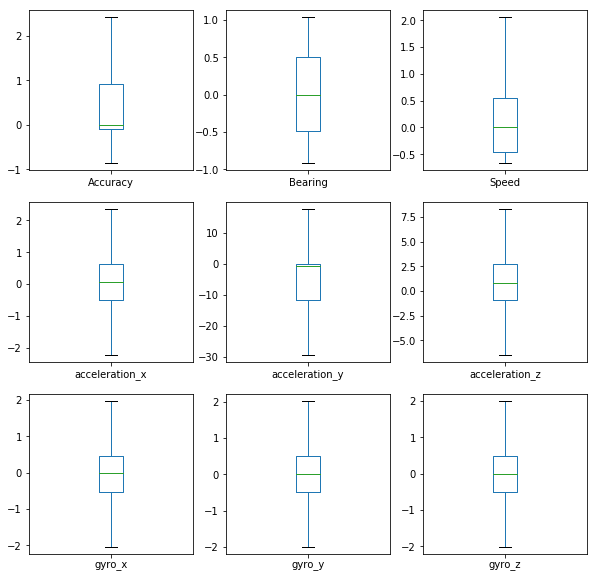

In [13]:
# box plot after scaling
plt.figure()
ax1 = plt.subplot(331)
features_df.Accuracy.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax1)
ax2 = plt.subplot(332)
features_df.Bearing.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax2)
ax3 = plt.subplot(333)
features_df.Speed.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax3)
ax4 = plt.subplot(334)
features_df.acceleration_x.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax4)
ax5 = plt.subplot(335)
features_df.acceleration_y.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax5)
ax6 = plt.subplot(336)
features_df.acceleration_z.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax6)
ax7 = plt.subplot(337)
features_df.gyro_x.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax7)
ax8 = plt.subplot(338)
features_df.gyro_y.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax8)
ax9 = plt.subplot(339)
features_df.gyro_z.plot(kind='box', figsize=[10,10], showfliers=False, ax=ax9)

## padding

In order to run CNN on the training data, let's pad all trips with 0 so that they have the same length (1 hour)

In [14]:
# create table keys
unique_bookingID = features_df[['bookingID']].drop_duplicates().sort_values('bookingID')
unique_second = pd.DataFrame(data=list(np.arange(0,3600,1.0)), columns=["second"])

In [15]:
# cartesian product with keys
unique_bookingID['key'] = 0
unique_second['key'] = 0
bookingID_second = unique_bookingID.merge(unique_second, on='key', how='outer').drop(columns=['key'])

In [16]:
# outer join with features by bookingID and second
features_df = bookingID_second.merge(features_df, on=['bookingID', 'second'], how='outer')

In [17]:
# padding
features_df.fillna(0, inplace=True)

In [18]:
# check features df shape after padding
features_df.shape[0]==unique_bookingID.shape[0]*unique_second.shape[0]

True

## convert features df to 3d array

* array dimension = (#bookings, #seconds, #features)
* this will take a while

In [19]:
# GPS features

print(time.strftime("%H:%M:%S"),": start Accuracy")
accuracy_arr = features_df.pivot_table(index="bookingID", columns="second", values="Accuracy").values

print(time.strftime("%H:%M:%S"),": start Bearing")
bearing_arr = features_df.pivot_table(index="bookingID", columns="second", values="Bearing").values

print(time.strftime("%H:%M:%S"),": start Speed")
speed_arr = features_df.pivot_table(index="bookingID", columns="second", values="Speed").values

21:32:04 : start Accuracy
21:32:45 : start Bearing
21:33:27 : start Speed


In [20]:
# acceleration

print(time.strftime("%H:%M:%S"),": start acceleration_x")
acceleration_x_arr = features_df.pivot_table(index="bookingID", columns="second", values="acceleration_x").values

print(time.strftime("%H:%M:%S"),": start acceleration_y")
acceleration_y_arr = features_df.pivot_table(index="bookingID", columns="second", values="acceleration_y").values

print(time.strftime("%H:%M:%S"),": start acceleration_z")
acceleration_z_arr = features_df.pivot_table(index="bookingID", columns="second", values="acceleration_z").values

21:34:08 : start acceleration_x
21:34:47 : start acceleration_y
21:35:26 : start acceleration_z


In [22]:
# gyro

print(time.strftime("%H:%M:%S"),": start gyro_x")
gyro_x_arr = features_df.pivot_table(index="bookingID", columns="second", values="gyro_x").values

print(time.strftime("%H:%M:%S"),": start gyro_y")
gyro_y_arr = features_df.pivot_table(index="bookingID", columns="second", values="gyro_y").values

print(time.strftime("%H:%M:%S"),": start gyro_z")
gyro_z_arr = features_df.pivot_table(index="bookingID", columns="second", values="gyro_z").values

21:38:11 : start gyro_x
21:38:55 : start gyro_y
21:39:33 : start gyro_z


In [23]:
# stack all features together to create a 3d array
features_arr = np.stack((accuracy_arr, bearing_arr, speed_arr, 
                         acceleration_x_arr, acceleration_y_arr, acceleration_z_arr, 
                         gyro_x_arr, gyro_y_arr, gyro_z_arr), axis=2)

In [24]:
features_arr.shape

(19968, 3600, 9)

## convert lables df to array

* array dimension = (#bookings, 1)

In [25]:
labels_arr = labels_df.sort_values('bookingID')[['label']].values

In [26]:
labels_arr.shape

(19968, 1)

## save processed training data

In [29]:
# save features array
save_path = 'data/safety/features_arr.npy'
np.save(save_path, features_arr)

In [30]:
# save labels array
save_path = 'data/safety/labels_arr.npy'
np.save(save_path, labels_arr)